<a href="https://colab.research.google.com/github/hoo1suu/AI_cover/blob/main/aicover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/ardha27/AICoverGen-NoUI-Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title 깃클론
!git clone https://github.com/SociallyIneptWeeb/AICoverGen.git
%cd AICoverGen

fatal: destination path 'AICoverGen' already exists and is not an empty directory.
/content/AICoverGen


In [ ]:
#@title 라이브러리 설치
!pip install pip==24.0.0
!pip install -q -r requirements.txt

# 필수 라이브러리 설치
!pip install pyworld praat-parselmouth faiss-cpu ffmpeg-python fairseq onnxruntime pedalboard yt_dlp sox gradio

# 추가 시스템 패키지 설치
!sudo apt update
!sudo apt install -y sox

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with 

In [ ]:
#@title MDXNet 보컬 분리 및 Hubert Base 모델 다운로드
!python src/download_models.py


All models downloaded!


Example of generated audio path

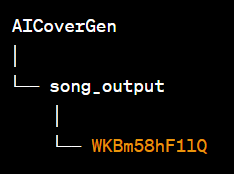

In [ ]:
import gradio as gr
import subprocess
import os
import zipfile
import shutil

def load_model(uploaded_file, model_name):
    try:
        # 현재 작업 디렉토리 설정
        BASE_DIR = os.getcwd()
        rvc_models_dir = os.path.join(BASE_DIR, 'rvc_models')

        # zip 파일을 추출하는 함수
        def extract_zip(extraction_folder, zip_name):
            os.makedirs(extraction_folder, exist_ok=True)
            with zipfile.ZipFile(zip_name, 'r') as zip_ref:
                zip_ref.extractall(extraction_folder)
            os.remove(zip_name)

            index_filepath, model_filepath = None, None
            for root, dirs, files in os.walk(extraction_folder):
                for name in files:
                    if name.endswith('.index') and os.stat(os.path.join(root, name)).st_size > 1024 * 100:
                        index_filepath = os.path.join(root, name)
                    if name.endswith('.pth') and os.stat(os.path.join(root, name)).st_size > 1024 * 1024 * 40:
                        model_filepath = os.path.join(root, name)
            if not model_filepath:
                raise Exception(f'추출된 zip에서 .pth 모델 파일을 찾을 수 없습니다. {extraction_folder}를 확인하세요.')
            os.rename(model_filepath, os.path.join(extraction_folder, os.path.basename(model_filepath)))
            if index_filepath:
                os.rename(index_filepath, os.path.join(extraction_folder, os.path.basename(index_filepath)))
            for filepath in os.listdir(extraction_folder):
                if os.path.isdir(os.path.join(extraction_folder, filepath)):
                    shutil.rmtree(os.path.join(extraction_folder, filepath))

        # 업로드된 파일 경로 저장
        extraction_folder = os.path.join(rvc_models_dir, model_name)
        uploaded_file_path = uploaded_file.name

        # zip 파일을 추출
        extract_zip(extraction_folder, uploaded_file_path)
        return f"모델 '{model_name}'이 성공적으로 로드되었습니다!"
    except Exception as e:
        return str(e)

# 오디오 변환 함수 정의
def convert_audio(song_url, model_name, pitch_change, output_format):
    try:
        # pitch_change를 int로 변환
        pitch_change = int(pitch_change)

        # 변환 명령어 실행
        command = [
            "python", "src/main.py",
            "-i", song_url,  # 입력된 노래 URL
            "-dir", model_name,  # 음성 모델 디렉토리
            "-p", str(pitch_change),  # 피치 변환 값
            "-k",
            "-oformat", output_format  # 출력 형식
        ]

        process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)

        # 실시간으로 출력 및 에러 수집
        output = ""
        for line in process.stdout:
            output += line + "\n"  # 출력 내용을 누적

        for line in process.stderr:
            output += "ERROR: " + line + "\n"  # 에러 내용을 누적

        process.wait()
        return output
    except Exception as e:
        return str(e)

# Gradio 인터페이스 정의
def gradio_ui():
    with gr.Blocks() as demo:
        gr.Markdown("# RVC 음성 변환 - Gradio UI")

        # 모델 로드 섹션
        with gr.Row():
            model_file = gr.File(label="모델 파일 업로드 (zip 파일)", file_types=[".zip"])
            model_name = gr.Textbox(label="모델 이름", placeholder="모델 디렉토리 이름 입력")
            load_btn = gr.Button("모델 로드")
            model_output = gr.Textbox(label="모델 상태", placeholder="모델 로드 결과")

        # 변환 섹션
        with gr.Row():
            song_url = gr.Textbox(label="노래 YouTube 링크", placeholder="YouTube URL 입력")
            pitch_change = gr.Slider(label="피치 변경", minimum=-12, maximum=12, step=1, value=0)  # 피치 변경 값 설정
            output_format = gr.Dropdown(choices=["mp3", "wav"], label="출력 형식", value="mp3")
            convert_btn = gr.Button("변환 실행")
            conversion_output = gr.Textbox(label="변환 결과", placeholder="변환 진행 상태 또는 결과", lines=10)

        # 버튼 동작 정의
        load_btn.click(fn=load_model, inputs=[model_file, model_name], outputs=[model_output])
        convert_btn.click(fn=convert_audio, inputs=[song_url, model_name, pitch_change, output_format], outputs=[conversion_output])

    return demo

# Gradio UI 실행
gradio_ui().launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
IMPORTANT: You are using gradio version 3.39.0, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://a82df520bb7c2f68bc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
